<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/310_subj_prop.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(cap-subj-prop)=
# Pensare ad una proporzione in termini soggettivi

Questo capitolo ha l'obiettivo di chiarire il concetto di aggiornamento bayesiano, introdotto nel capitolo precedente, attraverso l'uso di un esempio numerico in una situazione particolarmente semplice. In particolare, esamineremo come sia possibile aggiornare le nostre credenze riguardo alla probabilità ($\theta$) di un evento specifico.

Cominceremo affrontando la questione della rappresentazione delle credenze iniziali, cioè le opinioni che abbiamo prima di osservare i dati, mediante l'uso di una distribuzione a priori. Successivamente, spiegheremo i calcoli necessari per ottenere la distribuzione a posteriori di $\theta$. Questa distribuzione riflette la nostra credenza aggiornata su $\theta$ dopo aver osservato i dati. La distribuzione a posteriori si ottiene moltiplicando la distribuzione a priori per la verosimiglianza e quindi normalizzando il risultato mediante una costante.

Nel corso di questo capitolo, ci concentreremo sul caso più semplice, ovvero il modello binomiale. Inizieremo esaminando il contesto in cui la distribuzione a priori è discreta e successivamente esploreremo il caso in cui questa assume una forma continua. Per una trattazione più approfondita, è possibile fare riferimento al settimo capitolo del libro di {cite:t}`albert_2019prob`.


## Preparazione del Notebook

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import seaborn as sns

In [32]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

## Flusso di lavoro

Proseguiamo con l'esempio di {cite:t}`McElreath_rethinking` discusso nel precedente capitolo. Supponiamo di volere stimare la proporzione della superficie terrestre coperta d'acqua. Usiamo il metodo proposto da {cite:t}`McElreath_rethinking`: lanciamo in aria il mappamondo e registriamo se la superficie sotto il nostro indice destro è terra o acqua. In 9 lanci otteniamo "acqua" 6 volte e "terra" 3 volte. Questi sono i dati dell'esperimento casuale.

Prima di procedere, ricordiamo il flusso di lavoro proposto da {cite:t}`McElreath_rethinking`:

### 1. Definire un Modello Generativo del Campione
Un modello generativo descrive come i tuoi dati sono stati generati. In questo caso, consideriamo ogni lancio del globo come una prova di Bernoulli con due esiti possibili: acqua (A) o terra (T). Sia $ \theta $ la probabilità di osservare acqua in ogni lancio. Il modello assume che ogni lancio sia indipendente e identicamente distribuito. Il processo generativo può essere descritto come:

$$ 
X_i \sim \text{Bernoulli}(\theta),
$$

per $ i = 1, 2, ..., 9 $, dove $ X_i $ è 1 se l'esito è acqua e 0 se è terra.

### 2. Definire uno Stimatore Specifico
Lo stimatore è la quantità che siamo interessati a stimare dai nostri dati. Qui, lo stimatore è la probabilità $ \theta $ che il lancio del mappamondo produca l'esito "acqua". Il nostro obiettivo è stimare questa probabilità basandoci sui dati osservati.

### 3. Progettare un Metodo Statistico per Produrre una Stima
Per stimare $ \theta $, useremo il metodo bayesiano. Nella statistica bayesiana, esprimiamo le nostre credenze priori su $ \theta $ tramite una distribuzione a priori e aggiorniamo questa con i dati per ottenere una distribuzione a posteriori. Una scelta comune per la priori in un modello Bernoulli/Binomiale è una distribuzione Beta, che è coniugata alla verosimiglianza Bernoulli e quindi semplifica il calcolo. Potremmo iniziare con una priori non informativa, come $ \text{Beta}(1, 1) $, che equivale a una distribuzione uniforme sull'intervallo [0, 1].

La funzione di verosimiglianza basata sui nostri dati (6 acqua e 3 terra) sarebbe la verosimiglianza binomiale:

$$ 
L(p) = {9 \choose 6} \theta^6 (1-\theta)^3.
$$

Combiniamo la priori e la verosimiglianza per ottenere la distribuzione a posteriori usando il teorema di Bayes:

$$
\text{Posteriore} \propto \text{Verosimiglianza} \times \text{Priori} 
$$

### 4. Testare (3) Usando (1)
Prima di analizzare i dati reali, possiamo eseguire un controllo predittivo a priori per vedere se il nostro modello è in grado di generare dati plausibili. Ciò implica simulare dati dal modello generativo utilizzando parametri estratti dalla priori. Dopo aver adattato il modello ai dati reali, possiamo anche eseguire controlli predittivi a posteriori per vedere se il modello, con parametri stimati dai dati, può generare dati simili a quelli osservati.

### 5. Analizzare il Campione, Riassumere
Infine, analizziamo i dati reali. Questo comporta il calcolo della distribuzione a posteriori (in generale, utilizzando metodi computazionali come il Markov Chain Monte Carlo, MCMC) e riassumerla per fare inferenza su $ \theta $. Possiamo riassumere la distribuzione a posteriori utilizzando misure come la media, la mediana e gli intervalli di credibilità.

In questo capitolo mostreremo come sia possibile generare la distribuzione a posteriori con metodi numerici. Nei capitoli successivi esploreremo gli altri passi del flusso di lavoro proposto da {cite:t}`McElreath_rethinking`.

## Aggiornamento bayesiano con una distribuzione a priori discreta 

L'aggiornamento bayesiano è un processo fondamentale nell'ambito della statistica bayesiana, in cui le nostre conoscenze e convinzioni precedenti (priori) vengono aggiornate in base a nuove evidenze o dati, portando a una conoscenza aggiornata (posteriore). 

L'esempio presente  considera il problema di determinare la distribuzione a posteriori del parametro sconosciuto $\theta$ (probabilità di "acqua") [per una versione leggermente diversa di questo problema, si veda {cite:t}`albert_2019prob`]. In assenza di informazioni specifiche su $\theta$, potremmo essere tentati di assegnare a $\theta$ un valore arbitrario, come 0.5, ma questo non riflette adeguatamente la nostra incertezza. Invece, è più appropriato considerare un insieme di valori possibili per $\theta$, ciascuno con un certo grado di credibilità.

Per rappresentare questa incertezza, possiamo utilizzare una distribuzione a priori discreta. Questa distribuzione assegna una probabilità a ciascun valore plausibile di $\theta$, permettendoci di esprimere in modo chiaro e completo la nostra opinione iniziale su questi valori. 

Ad esempio, se consideriamo undici valori potenziali per $\theta$, potremmo assegnare una probabilità a priori a ciascuno di questi valori. Questi valori potrebbero essere, per esempio, 0, 0.1, 0.2, ..., fino a 1. La distribuzione a priori potrebbe essere uniforme, dove ogni valore ha la stessa probabilità, oppure potrebbe essere non uniforme, riflettendo credenze specifiche su alcuni valori di $\theta$.

Una volta osservati i dati (ad esempio, 6 volte "acqua" e 3 volte "terra"), queste informazioni vengono incorporate nella distribuzione a priori per aggiornarla in una distribuzione a posteriori. Questo si fa tramite il teorema di Bayes, che combina la probabilità a priori di $\theta$ con la verosimiglianza dei dati osservati per ottenere la probabilità a posteriori di $\theta$.

La distribuzione a posteriori riflette quindi una sintesi delle nostre convinzioni iniziali e delle nuove informazioni fornite dai dati, offrendoci una visione aggiornata del possibile valore del parametro $\theta$. Questo approccio fornisce un metodo rigoroso e flessibile per aggiornare le nostre credenze alla luce di nuove evidenze.

Consideriamo i seguenti valori plausibili per $\theta$.

In [33]:
theta = np.linspace(0, 1, 11)
print(theta)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Nel caso in cui non esistano motivi significativi per effettuare scelte diverse, è possibile assegnare la stessa probabilità a ciascun valore di `theta`. È fondamentale prestare attenzione alla seconda riga di codice, poiché essa esegue una standardizzazione. Poiché `unif_discr_pdf` è un vettore composto da un numero finito di elementi, è corretto considerare questi elementi come probabilità, e queste probabilità devono obbligatoriamente sommarsi a uno.

In [34]:
unif_distr_pdf = stats.uniform.pdf(theta) 
unif_distr_pdf = unif_distr_pdf / np.sum(unif_distr_pdf)
unif_distr_pdf

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

Una rappresentazione grafica di questa distribuzione di massa di probabilità si ottiene nel modo seguente.

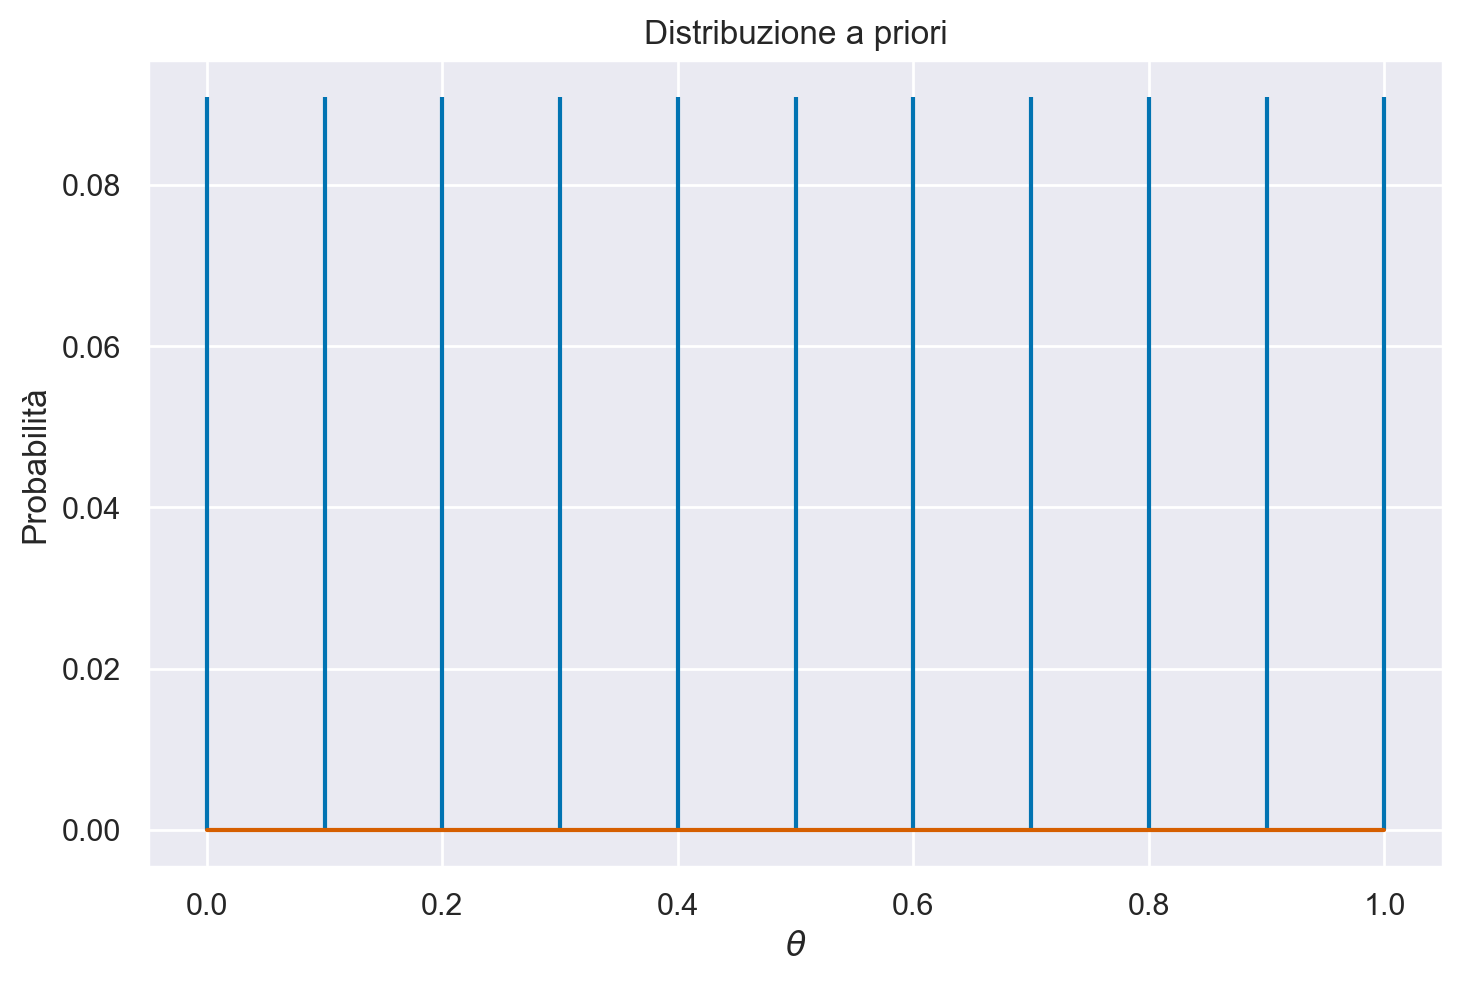

In [35]:
plt.stem(theta, unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità");

Se, al contrario, riteniamo che i valori centrali nella distribuzione di $\theta$ siano più credibili rispetto a quelli situati agli estremi, possiamo esprimere questa opinione soggettiva mediante la seguente distribuzione di massa di probabilità.

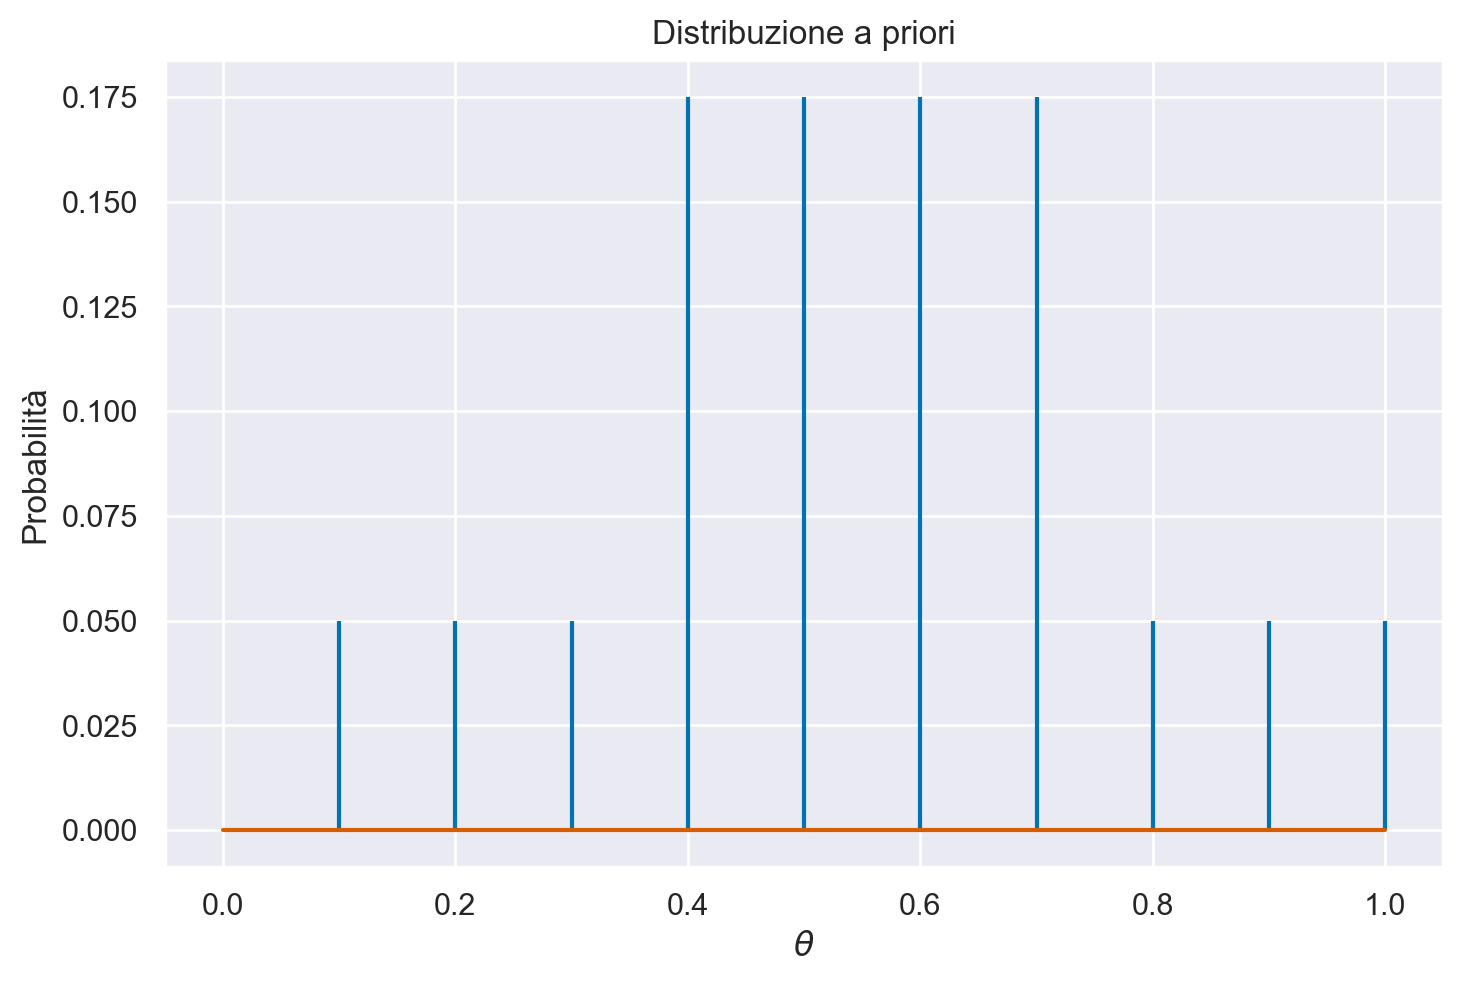

In [36]:
not_unif_distr_pdf = [0, 0.05, 0.05, 0.05, 0.175, 0.175, 0.175, 0.175, 0.05, 0.05, 0.05]
plt.stem(theta, not_unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità");

La prima distribuzione di probabilità rappresenta una distribuzione discreta uniforme poiché assegna la stessa probabilità a ciascun elemento dell'insieme discreto su cui è definita, ossia i valori ${0, 0.1, 0.2, \dots, 1.0}$. La seconda distribuzione di probabilità, pur essendo discreta, segue un andamento non uniforme: si presume che $\theta$ abbia una probabilità maggiore di assumere un valore dall'insieme ${0.4, 0.5, 0.6, 0.7}$ rispetto all'insieme ${0.1, 0.2, 0.3, 0.8, 0.9, 1.0}$.

Le credenze iniziali riguardo ai possibili valori di $\theta$ costituiscono la "distribuzione a priori". L'inferenza bayesiana aggiorna queste credenze iniziali utilizzando le informazioni ottenute dai dati. Queste informazioni vengono combinate con le credenze iniziali su $\theta$ attraverso l'applicazione del teorema di Bayes, allo scopo di ottenere la "distribuzione a posteriori". Quest'ultima rappresenta le nostre credenze aggiornate sui possibili valori di $\theta$ dopo l'osservazione dei dati.

Supponiamo di aver osservato 6 "successi" (acqua) in 9 prove. Per calcolare la distribuzione a posteriori, utilizzeremo come esempio la seconda delle due distribuzioni a priori precedentemente descritte. In base al teorema di Bayes, la distribuzione a posteriori si ottiene moltiplicando la verosimiglianza per la distribuzione a priori e quindi dividendo per una costante di normalizzazione:

$$
p(\theta \mid y) = \frac{p(y \mid \theta)p(\theta)}{p(y)}.
$$

Per calcolare la funzione di verosimiglianza, $p(y \mid \theta)$, dobbiamo comprendere il processo mediante il quale i dati sono stati generati. Nel nostro contesto, i dati rappresentano i risultati di 9 ripetizioni di un esperimento casuale che può produrre solo due risultati possibili: "acqua" e "terra". I 9 lanci del mappamondo sono tra loro indipendenti (avere osservato un determinato esito in una prova non influenza il risultato osservato nella prova successiva). In tali circostanze, possiamo assumere che il modello generativo dei dati sia il modello binomiale di probabilità sconosciuta $\theta$. 

Utilizzando Python, è possibile calcolare la funzione di verosimiglianza tramite la funzione `binom.pmf()`.

In [37]:
lk = stats.binom.pmf(6, 9, theta)
lk = lk / np.sum(lk)
lk

array([0.00000000e+00, 6.11961968e-05, 2.75072287e-03, 2.09902955e-02,
       7.42695176e-02, 1.63955860e-01, 2.50659622e-01, 2.66654495e-01,
       1.76046264e-01, 4.46120274e-02, 0.00000000e+00])

Per i 10 valori $\theta$ considerati, la funzione di verosimiglianza assume la forma indicata dalla figura seguente.

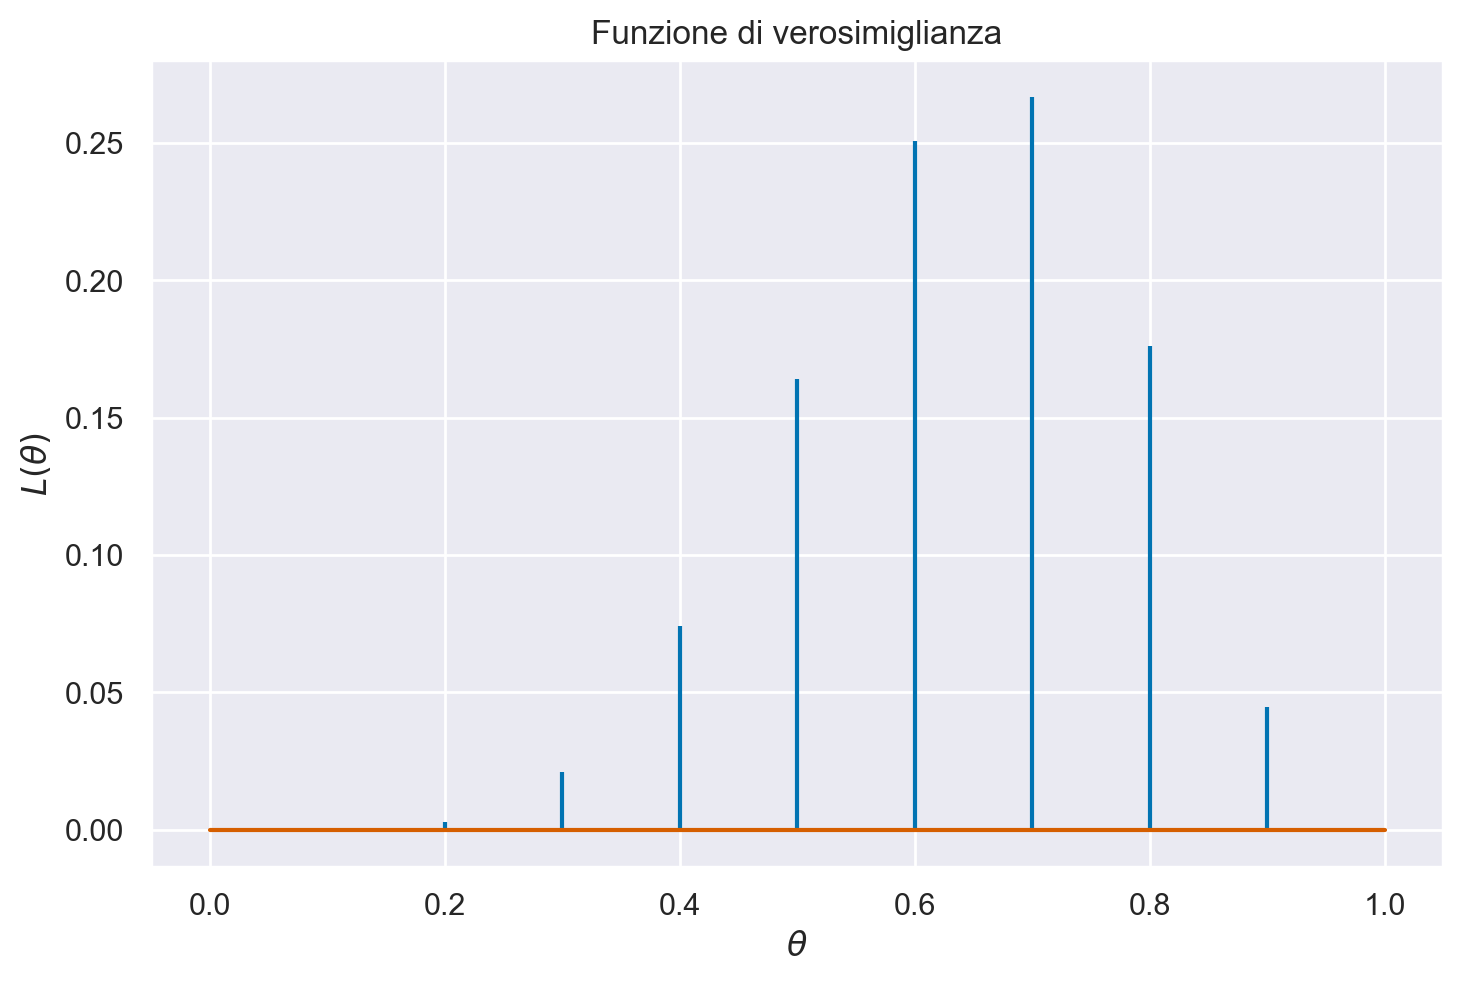

In [38]:
plt.stem(theta, lk, markerfmt=" ")
plt.title("Funzione di verosimiglianza")
plt.xlabel("$\\theta$")
plt.ylabel("$L(\\theta)$");

Per calcolare la distribuzione a posteriori, eseguiamo una moltiplicazione elemento per elemento tra il vettore contenente i valori della distribuzione a priori e il vettore contenente i valori della funzione di verosimiglianza. Usando Python, il risultato si trova nel modo seguente.

In [39]:
not_unif_distr_pdf * lk

array([0.00000000e+00, 3.05980984e-06, 1.37536144e-04, 1.04951477e-03,
       1.29971656e-02, 2.86922755e-02, 4.38654338e-02, 4.66645366e-02,
       8.80231320e-03, 2.23060137e-03, 0.00000000e+00])

Per illustrare con un esempio, il valore dell'ottavo elemento della distribuzione a posteriori si calcola come segue (tenendo presente che in Python gli indici partono da 0):

In [40]:
not_unif_distr_pdf[7] * lk[7]

0.04666453655213576

Dopo questa moltiplicazione, otteniamo una distribuzione che rappresenta le probabilità condizionate dei possibili valori di $\theta$ alla luce dei dati osservati. Tuttavia, questa distribuzione potrebbe non è normalizzata, il che significa che la somma di tutte le probabilità condizionate non è uguale a 1.

Per ottenere una distribuzione di probabilità correttamente normalizzata, dobbiamo dividere ciascun valore ottenuto precedentemente per la probabilità marginale dei dati $y$. La probabilità marginale dei dati $y$ è una costante di normalizzazione e può essere calcolata utilizzando la legge della probabilità totale (si veda l'eq. {eq}`eq-prob-tot`). 

Per chiarire, ricordiamo che, nel capitolo {ref}`cond-prob-notebook` abbiamo considerato il caso di una partizione dello spazio campione in due eventi mutualmente esclusivi ed esaustivi, $H_1$ e $H_2$. All'interno dello spazio campione abbiamo definito un evento $E$ non nullo e abbiamo visto che $P(E) = P(E \cap H_1) + P(E \cap H_2)$, ovvero $P(E) = P(E \mid H_1) P(H_1) + P(E \mid H_2) P(H_2)$. Usando la terminologia che stiamo usando qui, $P(E \mid H_i)$ corrisponde alla funzione di verosimiglianza e $P(H_i)$ corrisponde alla funzione a priori. Nel caso discreto, come quello che stiamo considerando ora, il teorema della probabilità totale ci dice dunque che dobbiamo fare la somma dei prodotti tra i valori della funzione di verosimiglianza e i corrispondenti valori della distribuzione a priori. 

In [41]:
np.sum(not_unif_distr_pdf * lk)

0.1444424367502889

Otteniamo dunque il seguente risultato.

In [42]:
post = (not_unif_distr_pdf * lk) / np.sum(not_unif_distr_pdf * lk)
print(post)

[0.00000000e+00 2.11835933e-05 9.52186538e-04 7.26597251e-03
 8.99816278e-02 1.98641591e-01 3.03687994e-01 3.23066667e-01
 6.09399384e-02 1.54428395e-02 0.00000000e+00]


Verifichiamo di avere ottenuto una distribuzione di massa di probabilità:

In [43]:
np.sum(post)

0.9999999999999998

Esaminiamo la distribuzione a posteriori di $\theta$ con un grafico.

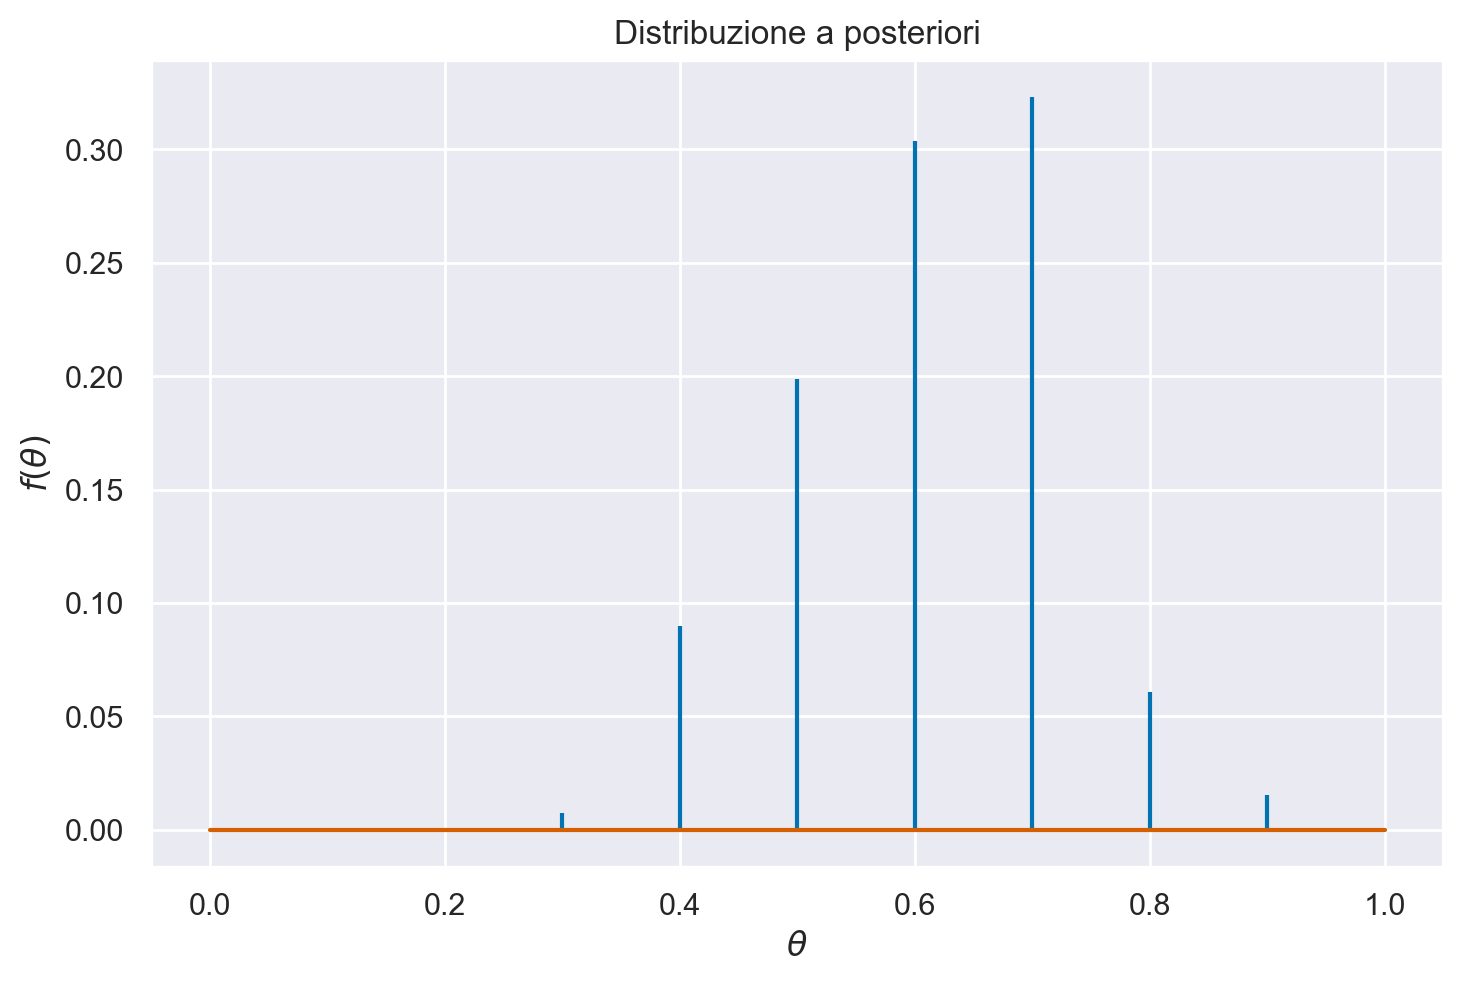

In [44]:
plt.stem(theta, post, markerfmt=" ")
plt.title("Distribuzione a posteriori")
plt.xlabel("$\\theta$")
plt.ylabel(r"$f(\theta)$");

Una volta trovata la distribuzione a posteriori di $\theta$, possiamo calcolare altre quantità di interesse. Ad esempio, la moda a posteriori di $\theta$ può essere individuata direttamente dal grafico precedente e risulta pari a 0.6. Per calcolare invece la media a posteriori, ci avvaliamo della formula del valore atteso delle variabili casuali.

In [45]:
np.sum(theta * post)

0.6086957633539818

La varianza della distribuzione a posteriori è

In [46]:
np.sum(theta**2 * post) - (np.sum(theta * post)) ** 2

0.013379767754025051

Con questo metodo, possiamo calcolare la distribuzione a posteriori di $\theta$ per qualsiasi distribuzione a priori discreta.

## Aggiornamento bayesiano con una distribuzione a priori continua 

A fini didattici, abbiamo esaminato il caso di una distribuzione a priori discreta. Tuttavia, è importante notare che l'impiego di una distribuzione a priori continua, come la distribuzione Beta, risulta più appropriato in quanto permette di rappresentare un'ampia gamma di possibili valori per il parametro non noto $\theta$, senza essere vincolati a un insieme discreto di valori. Inoltre, la distribuzione Beta presenta l'ulteriore vantaggio di avere un dominio definito nell'intervallo [0, 1], che corrisponde alla gamma dei possibili valori per la proporzione $\theta$.

Per esempio, consideriamo la distribuzione Beta(2, 2), caratterizzata da una simmetria nella sua forma. Per valutare la distribuzione Beta in corrispondenza di punti specifici, come ad esempio 0.5, 0.8 e 1.2, possiamo fare affidamento sulla funzione `beta.pdf`. A titolo illustrativo, la densità di probabilità della distribuzione Beta(2, 2) nel caso del valore 0.5 risulta essere 1.5, suggerendo che i valori di $\theta$ vicini a 0.5 appaiono più plausibili rispetto a quelli intorno a 0.8, dove la funzione assume un valore di 0.96. È importante sottolineare che la densità di probabilità della distribuzione Beta(2, 2) relativa al valore 1.2 è pari a 0, poiché tale valore esula dall'intervallo di definizione della distribuzione (0 e 1).

La distribuzione Beta(2, 2) è illustrata nella figura qui di seguito.

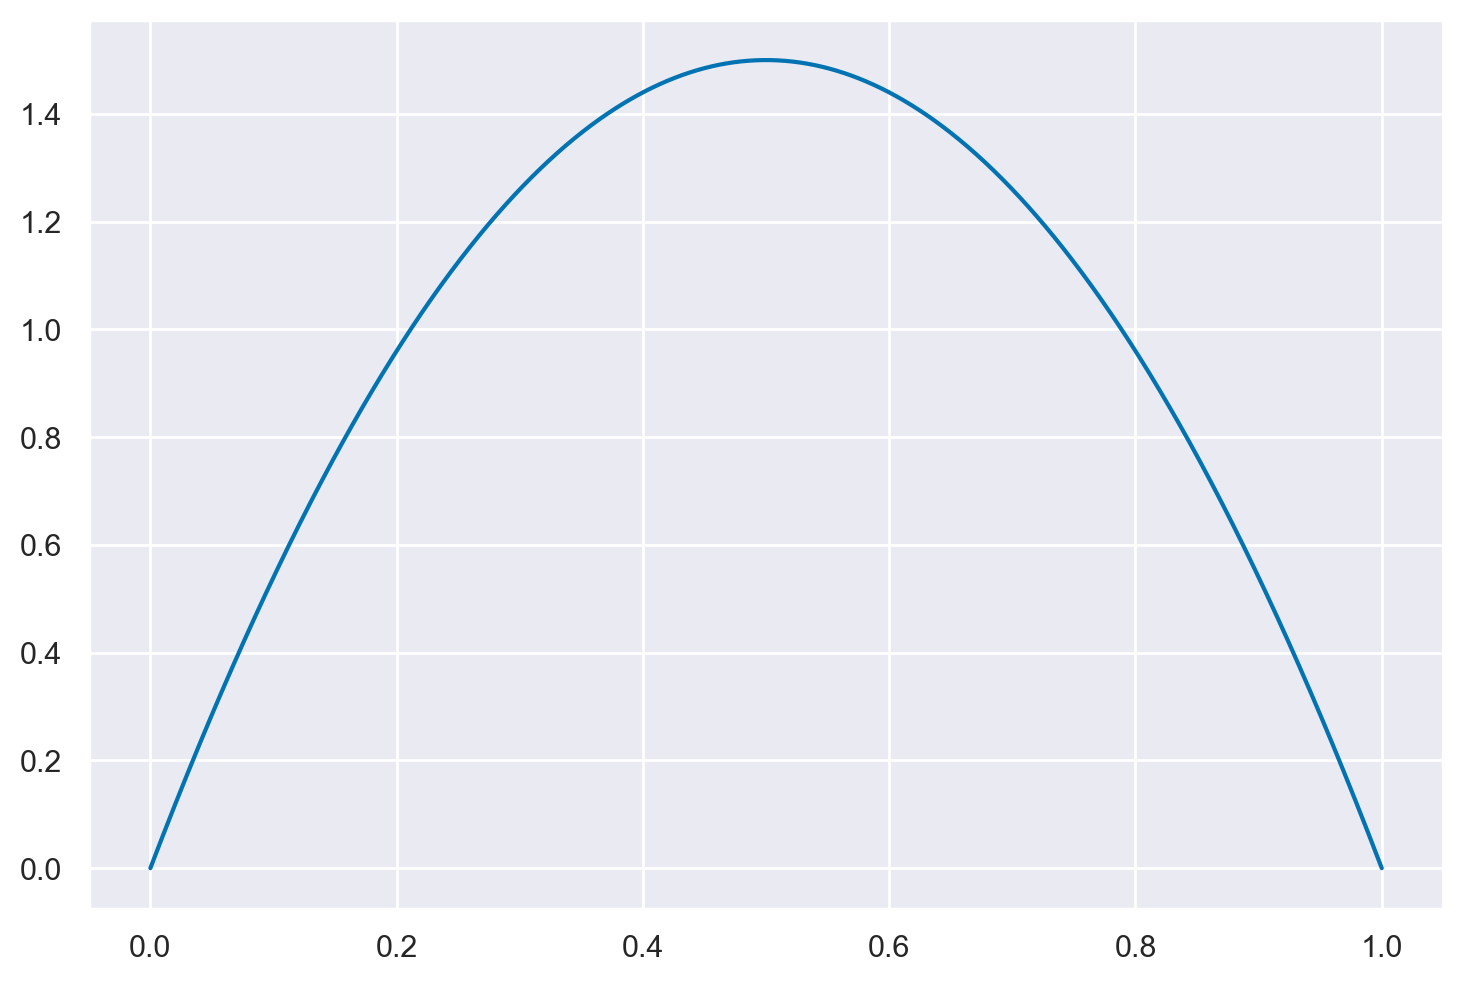

In [47]:
theta = np.linspace(0, 1, 1000)
_ = plt.plot(theta, stats.beta.pdf(theta, 2, 2), '-')

Nel seguente esempio, useremo la funzione `beta.pdf()` per generare una distribuzione a priori discretizzata. Supponiamo -- solo allo scopo di illustrare la procedura -- che le nostre credenze a priori siano rappresentate da una Beta(2, 5).

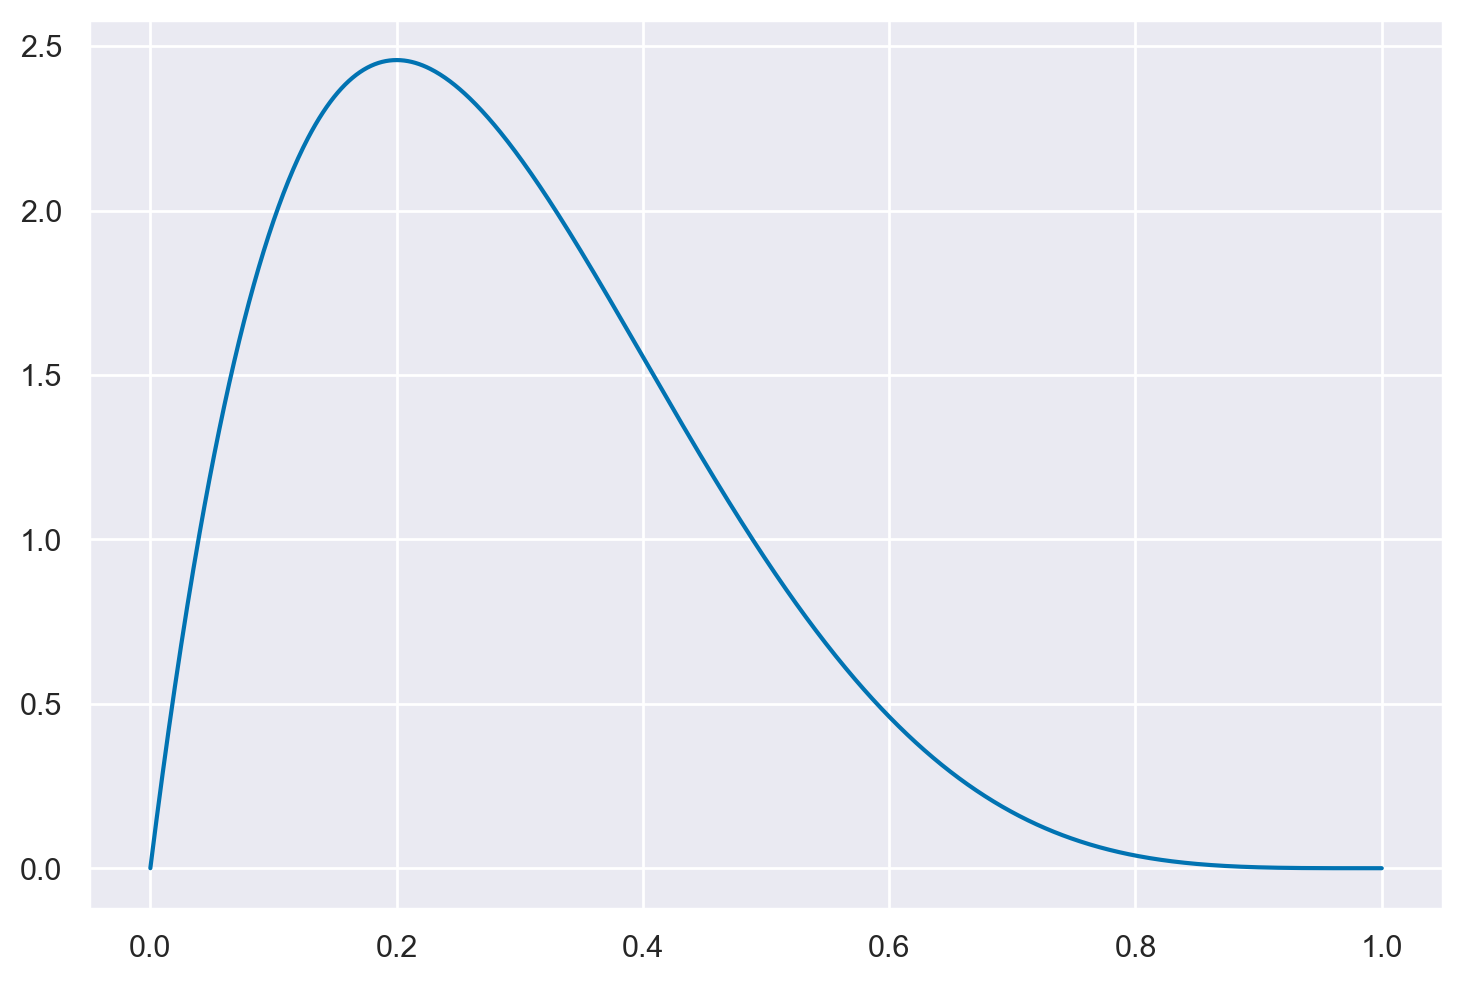

In [48]:
_ = plt.plot(theta, stats.beta.pdf(theta, 2, 5), '-')

Calcoliamo la distribuzione a priori normalizzata.

In [49]:
prior = stats.beta.pdf(theta, 2, 5) 
prior = prior / np.sum(prior)

Per calcolare la verosimiglianza, seguiamo la medesima procedura illustrata nel capitolo {ref}`cap-likelihood`. In aggiunta, effettuiamo la normalizzazione dei valori discretizzati della verosimiglianza, come precedentemente descritto.

In [50]:
lk = stats.binom.pmf(6, 9, theta)
lk = lk / np.sum(lk)

Infine, otteniamo la distribuzione a posteriori moltiplicando la distribuzione a priori per la verosimiglianza e dividendo per la costante di normalizzazione.

In [51]:
post = (prior * lk) / np.sum(prior * lk)

In [52]:
np.sum(post)

1.0

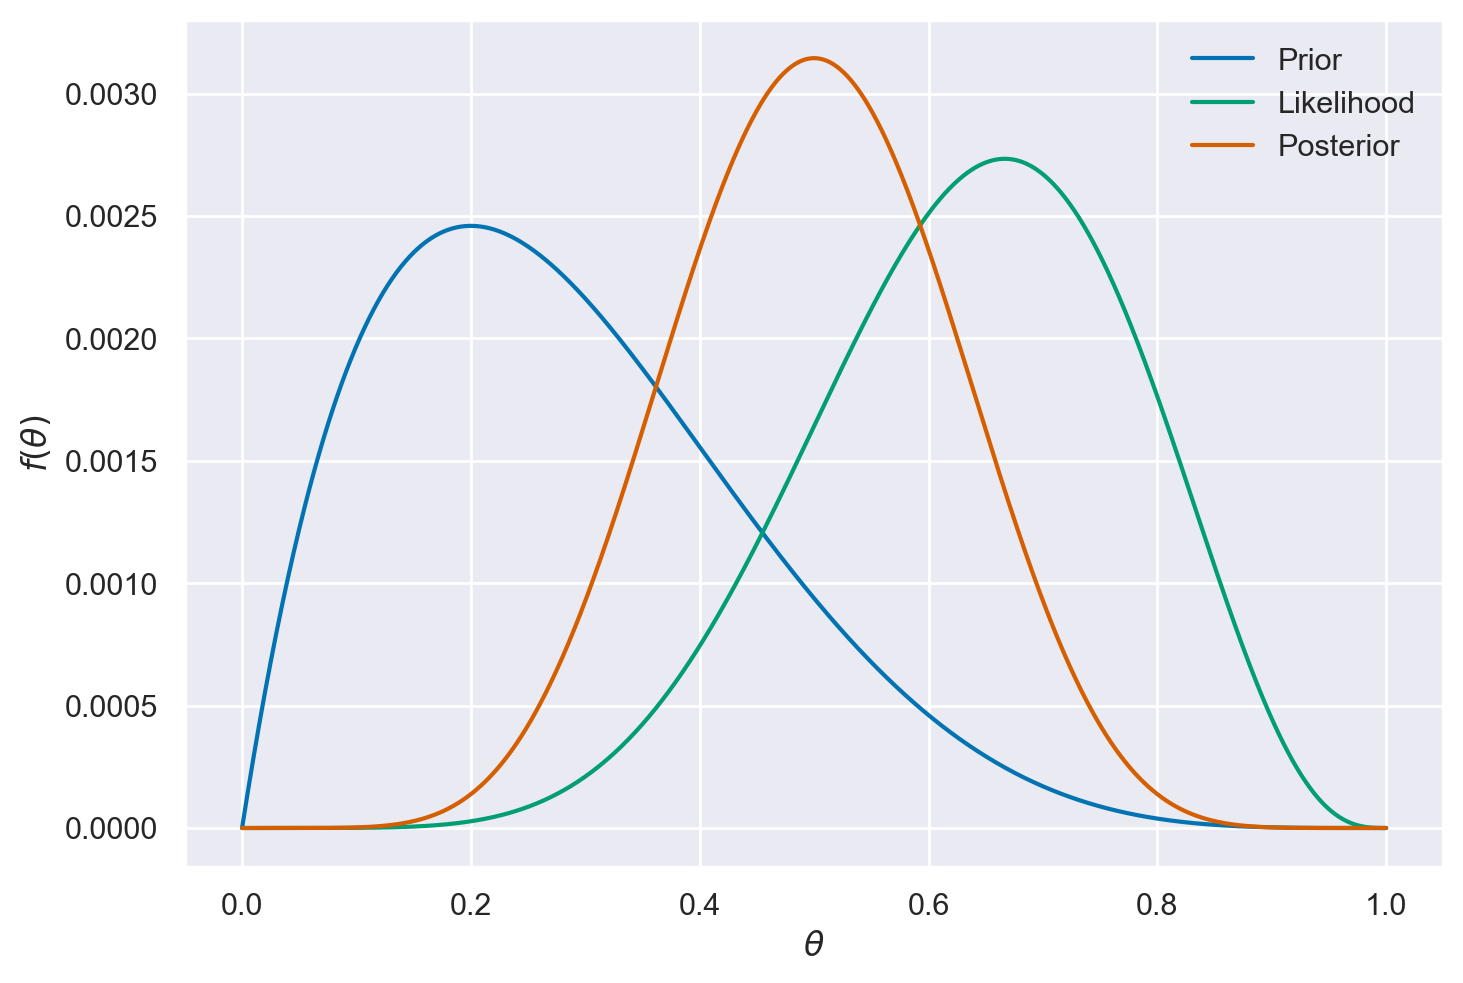

In [53]:
plt.plot(theta, prior, linestyle="solid", color="C0", label="Prior")
plt.plot(theta, lk, linestyle="solid", color="C2", label="Likelihood")
plt.plot(theta, post, linestyle="solid", color="C3", label="Posterior")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.show();

Possiamo calcolare la media e la deviazione standard della distribuzione a posteriori come abbiamo fatto in precedenza.

In [54]:
# media
np.sum(theta * post)

0.5

In [55]:
# deviazione standard
np.sqrt(np.sum(theta**2 * post) - (np.sum(theta * post)) ** 2)

0.1212678125181665

## Sintesi ed elaborazioni inferenziali sulla distribuzione a posteriori

Una volta ottenuta la distribuzione a posteriori, è possibile generare un campione casuale da questa distribuzione. A titolo di esempio, possiamo estrarre un campione di 10000 punti dalla distribuzione a posteriori di $\theta$ che abbiamo calcolato.

In [56]:
samples = np.random.choice(theta, p=post, size=int(1e4), replace=True)

L'istruzione precedente genera un array denominato `samples` contenente 10000 punti campionati dalla distribuzione a posteriori calcolata. La funzione `np.random.choice` viene impiegata per selezionare casualmente i valori `theta` basandosi sulle probabilità definite da `post`.

/var/folders/cl/wwjrsxdd5tz7y9jr82nd5hrw0000gn/T/ipykernel_91274/3061577581.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


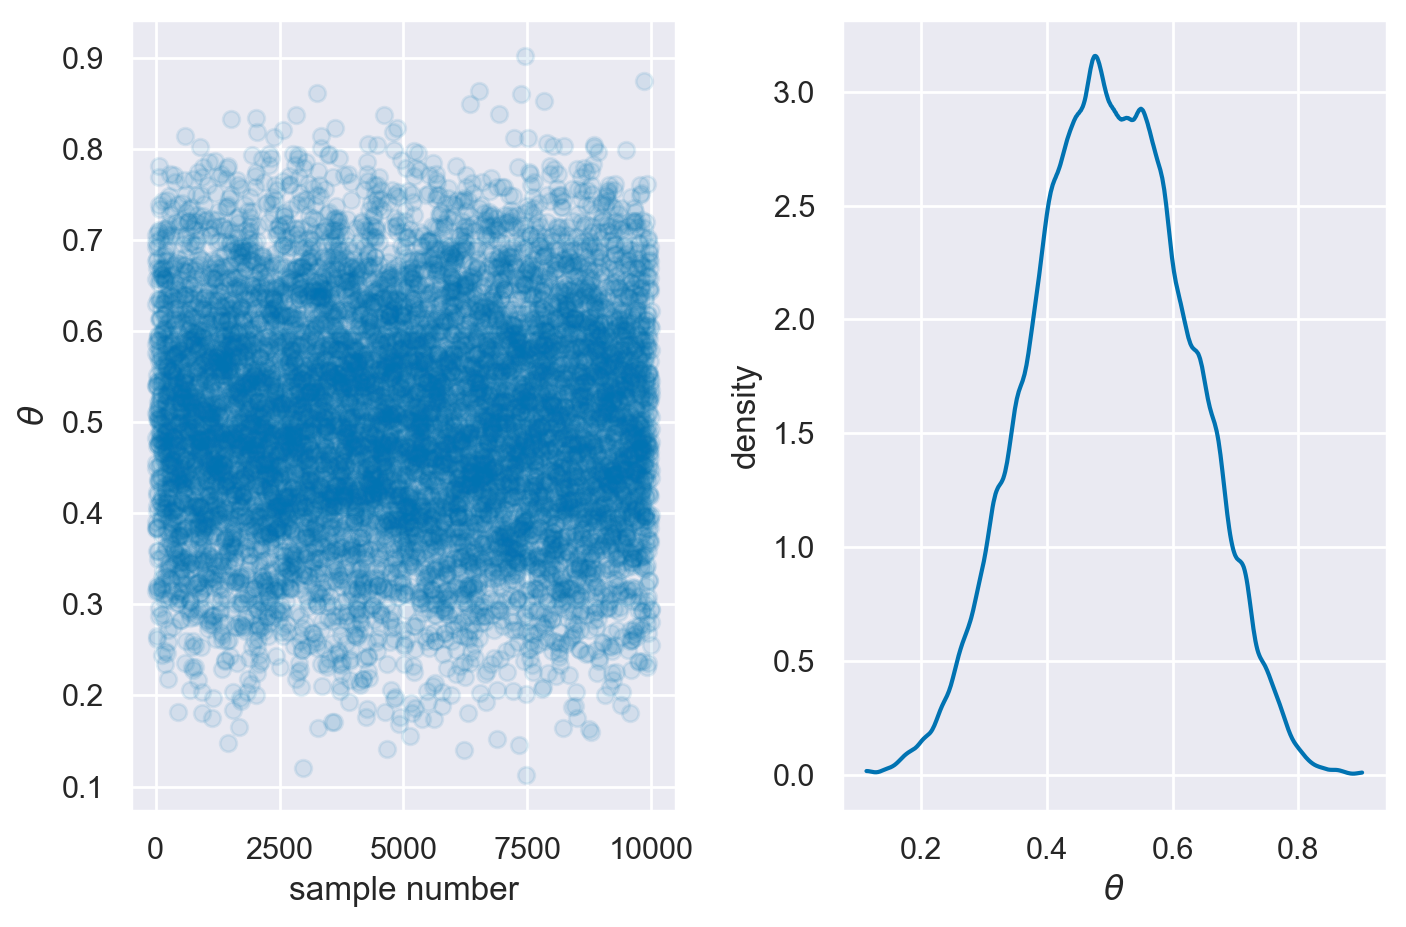

In [57]:
# First subplot: Scatter plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(samples, 'o', alpha=0.1)
plt.xlabel("sample number")
plt.ylabel(r"$\theta$")

# Second subplot: KDE plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
az.plot_kde(samples)
plt.xlabel(r"$\theta$")
plt.ylabel("density")
plt.tight_layout()
plt.show();

Sfruttando il campione estratto dalla distribuzione a posteriori, è possibile calcolare diverse quantità di interesse. Ad esempio, la stima della media a posteriori di $\theta$ si ottiene semplicemente calcolando la media dei valori così ottenuti.

In [58]:
np.mean(samples)

0.5003131131131132

In maniera analoga possiamo calcolare la deviazione standard della distribuzione a posteriori di $\theta$.

In [59]:
np.std(samples)

0.1220808540364525

La moda a posteriori si può calcolare nel modo seguente.

In [60]:
theta[post == max(post)]

array([0.4994995])

Oppure, usando il campione estratto dalla distribuzione a posteriori di $\theta$, otteniamo

In [61]:
stats.mode(samples)[0]

0.4794794794794795

Usando il campione estratto dalla distribuzione a posteriori, è immediato trovare la mediana a posteriori di $\theta$.

In [62]:
np.median(samples)

0.4984984984984985

Possiamo calcolare la probabilità di varie ipotesi relative a $\theta$ nella distribuzione a posteriori. Per esempio, calcoliamo la probabilità $P(\theta < 0.5)$. 

In [63]:
sum(post[theta < 0.5])

0.4999999999999997

Alternativamente, utilizzando il campione estratto dalla distribuzione a posteriori di $\theta$, otteniamo un risultato analogo, sebbene soggetto a variazioni dovute all'approssimazione numerica.

In [65]:
sum(samples < 0.5) / 1e4

0.5034

Possiamo trovare la probabilità a posteriori che $\theta$ sia compresa in un dato intervallo. Per esempio, troviamo $P(0.5 < \theta < 0.75)$.

In [67]:
sum((samples > 0.6) & (samples < 0.8)) / 1e4

0.2138

Utilizzando il campionamento effettuato dalla distribuzione a posteriori di $\theta$, è possibile risolvere il problema inverso, ovvero determinare l'intervallo che contiene $\theta$ con una specifica probabilità. Ad esempio, si può calcolare l'intervallo che ha una probabilità pari a 0.94 di contenere $\theta$, basandosi sulla distribuzione a posteriori campionata.

In [72]:
np.percentile(samples, [2, 98])

array([0.25625626, 0.74274274])

L'intervallo specificato è noto come *intervallo di credibilità* e rappresenta una quantificazione statistica dell'incertezza associata alla stima del parametro $\theta$. In termini probabilistici, si può affermare con il 94% di credibilità che il valore "vero" di $\theta$ è contenuto nell'intervallo [0.26, 0.74].

Se vogliamo trovare l'intervallo di credibilità a più alta densità a posteriori (HPD), usiamo la funzione ArviZ `hdi()` (si veda il capitolo {ref}`sintesi-distr-post-notebook`).

In [73]:
az.hdi(samples, hdi_prob=0.94)

array([0.27227227, 0.72072072])

Nel contesto attuale, la distribuzione a posteriori è simmetrica. Di conseguenza, l'intervallo di credibilità calcolato attraverso i quantili e l'intervallo di credibilità a più alta densità a posteriori (HPDI) sono sostanzialmente uguali.

## Qual è il modo migliore per stimare il parametro $\theta$?

Nonostante abbiamo discusso in precedenza dei diversi metodi di stima puntuale e intervallare per riassumere la distribuzione a posteriori di $\theta$, la migliore stima del parametro che stiamo cercando di inferire è rappresentata dall'intera distribuzione a posteriori. Per citare le parole di  {cite:t}`McElreath_rethinking`:

> That an arbitrary interval contains an arbitrary value is not meaningful. Use the whole distribution.

## Metodo basato su griglia

Il metodo utilizzato in questo capitolo per generare la distribuzione a posteriori è noto come metodo basato su griglia. Questo metodo numerico esatto si basa sul calcolo della distribuzione a posteriori mediante una griglia di punti uniformemente spaziati. Nonostante la maggior parte dei parametri sia continua, l'approssimazione della distribuzione a posteriori può essere ottenuta considerando soltanto una griglia finita di valori dei parametri. Il metodo segue quattro fasi:

1. Fissare una griglia discreta di possibili valori dei parametri.
2. Valutare la distribuzione a priori e la funzione di verosimiglianza per ciascun valore della griglia.
3. Calcolare l'approssimazione della densità a posteriori, ottenuta moltiplicando la distribuzione a priori per la funzione di verosimiglianza per ciascun valore della griglia e normalizzando i prodotti in modo che la loro somma sia uguale a 1.
4. Selezionare $n$ valori casuali dalla griglia per ottenere un campione casuale della densità a posteriori normalizzata.

Questo metodo può essere potenziato aumentando il numero di punti nella griglia, ma il limite principale risiede nel fatto che all'aumentare della dimensionalità dello spazio dei parametri, il numero di punti necessari per una stima accurata cresce in modo esponenziale, rendendo il metodo impraticabile per problemi complessi.

In sintesi, l'approccio basato sulla griglia è intuitivo e non richiede competenze di programmazione avanzate per l'implementazione. Inoltre, fornisce un risultato che può essere considerato, per tutti gli scopi pratici, come un campione casuale estratto dalla distribuzione di probabilità a posteriori condizionata ai dati. Tuttavia, questo metodo è limitato a causa della *maledizione della dimensionalità*[^036_posterior_sim-1], il che significa che può essere applicato soltanto a modelli statistici semplici con non più di due parametri. Di conseguenza, in pratica, è spesso sostituito da altre tecniche più efficienti, poiché i modelli impiegati in psicologia richiedono frequentemente la stima di centinaia o anche migliaia di parametri.

[^036_posterior_sim-1]: Per comprendere la maledizione della dimensionalità, possiamo considerare l'esempio di una griglia di 100 punti equispaziati. Nel caso di un solo parametro, sarebbe necessario calcolare solo 100 valori. Tuttavia, se abbiamo due parametri, il numero di valori da calcolare diventa $100^2$. Se invece abbiamo 10 parametri, il numero di valori da calcolare sarebbe di $10^{10}$. È evidente che la quantità di calcoli richiesta diventa troppo grande persino per un computer molto potente. Pertanto, per modelli che richiedono la stima di un numero significativo di parametri, è necessario utilizzare un approccio diverso.

## Commenti e considerazioni finali 

In questo capitolo, abbiamo esplorato l'aggiornamento bayesiano all'interno del quadro di una distribuzione a priori di natura discreta, con una breve menzione riguardante il caso di distribuzioni a priori continue. Quando affrontiamo scenari in cui la distribuzione a priori è continua, l'elaborazione della distribuzione a posteriori implica generalmente la risoluzione di un integrale che, nella maggior parte dei casi, non ammette una soluzione analitica. Tuttavia, esistono eccezioni notevoli, come nel contesto dell'inferenza relativa a proporzioni, dove la distribuzione a priori è modellizzata come una distribuzione Beta e la funzione di verosimiglianza segue una distribuzione binomiale. In queste circostanze particolari, è possibile derivare analiticamente la distribuzione a posteriori. L'analisi dettagliata di questo caso sarà l'oggetto del capitolo successivo. 

Il punto importante della presente discussione risiede nell'approccio adottato per affrontare una questione di ricerca particolare, ossia quella relativa alla quantità di superficie terrestre coperta da acqua. Abbiamo illustrato come sia possibile mettere in pratica alcuni degli step del flusso di lavoro proposto da {cite:t}`McElreath_rethinking`. In particolare, in questo capitolo, abbiamo esaminato come sia possibile implementare i punti 1, 2, 3 e 5 del flusso di lavoro bayesiano.

In [74]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sun Jan 28 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

arviz     : 0.17.0
scipy     : 1.11.4
numpy     : 1.26.2
seaborn   : 0.13.0
matplotlib: 3.8.2
pandas    : 2.1.4

Watermark: 2.4.3

